In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import os
import lightnet as ln
from test_script import test_step
from utils import draw_bounding_boxes, mean_average_precision, to_pixel_coords, to_xyxy_coords
from lightnet.util import iou_cwh, iou_tlwh

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TEST_IMG_DIR = "data/data_split/test/images"
TEST_LABEL_DIR =  "data/data_split/test/labels"
TEST_DEPTH_DIR = "data/data_split/test/depth"
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3
MODEL_TYPE = "depth"
print(f"Using Device {DEVICE}")

model = ln.models.YoloV2(NUM_CLASSES)
model.load('models/5_epochs_split.pt', strict=False)
model.to(DEVICE)

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
    model_type=MODEL_TYPE
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Using Device cuda


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [3]:
do_test = True
if do_test:
    metric_map, test_loss, pred_boxes, true_boxes = test_step(
        model=model,
        dataloader=test_dataloader,
        batch_size=BATCH_SIZE,
        loss_fn=loss_fn,
        device=DEVICE
    )

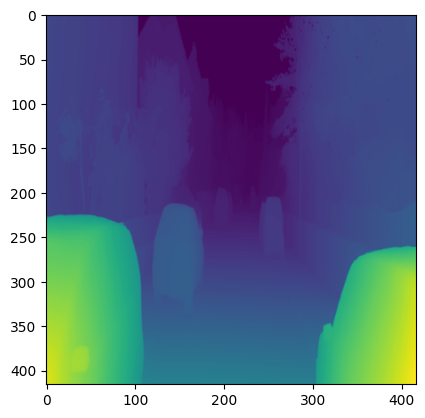

In [7]:
import matplotlib.pyplot as plt
index = 3
image, target = test_dataset[index]
plt.imshow(image.squeeze(0))

In [4]:
metric_map

(tensor(0.1621), [tensor(0.0293), tensor(0.0410), tensor(0.4160)])

In [5]:
test_loss

1.8449365659914119

In [7]:
model_2 = ln.models.YoloV2(NUM_CLASSES)
model_2.load('models/5_epochs_split.pt', strict=False)
model_2.to(DEVICE)

YoloV2(
  (backbone): FeatureExtractor(
    selection=[17_convbatch], return=True
    (module): Sequential(
      (1_convbatch): Conv2dBatchAct(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3_convbatch): Conv2dBatchAct(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (6_convbatch): Conv2dBatchAct(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), LeakyReLU(negative_slope=0.1, inplace=True))
      (7_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (8_m

In [8]:
GetBoxes_fn = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.5,
                network_stride=model.stride,
                anchors=model.anchors
            )

nms_fn = ln.data.transform.NMS(
    iou_thresh=.3,
    class_nms=True
)

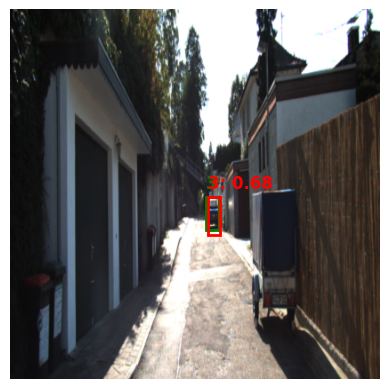

In [9]:
# good indexes: 785, 512, 1023

draw_bounding_boxes(index=0, 
                    model=model_2, 
                    dataset=test_dataset, 
                    GetBoxes_fn=GetBoxes_fn, 
                    nms_fn=nms_fn, 
                    class_names=["1", "2", "3"], 
                    device=DEVICE)

In [ ]:
# INPUT IS A BATCH
true_boxes = []
pred_boxes = []
batch_index = 0
for index, (X, y) in enumerate(test_dataloader):
    batch_size = len(y["boxes"])
    model_input = X.to(DEVICE)
    model_2.to(DEVICE)
    model_2.eval()

    with torch.inference_mode():
        model_output = model_2(model_input)

    box_tensor = GetBoxes_fn(model_output.cpu())
    output_boxes = nms_fn(box_tensor)
    for img_index, boxes in enumerate(y["boxes"]):
        for box in boxes:
            if box[0].item() == -1: #supress the padding
                continue
            # works with xyxy coords only!
            #x1, y1, x2, y2 = box[1:]*416
            x1, y1, x2, y2 = to_xyxy_coords(box[1:], 416, 416)
            # add image index on the list
            
            true_box = [img_index+index*batch_size, box[0].item(), 1, x1.item(), y1.item(), x2.item(), y2.item()] 
            true_boxes.append(true_box)
        
    for bbox in output_boxes:
        # works with xyxy coords only!
        x1, y1, x2, y2 = to_xyxy_coords(bbox[1:5], 1, 1)
        #x1, y1, x2, y2 = bbox[1:5]
       
        pred_box = [bbox[0].item()+index*batch_size, 
        bbox[6].item(), 
        bbox[5].item() , 
        x1.item(), 
        y1.item(),
        x2.item(), 
        y2.item()]

        pred_boxes.append(pred_box)
   
    if index == batch_index:
        break
    
pred_boxes = sorted(pred_boxes, key=lambda x: x[0])

In [8]:
mean_average_precision(pred_boxes=pred_boxes, true_boxes=true_boxes, iou_threshold=0.5, box_format="corners", num_classes=3)

(tensor(0.1261), [tensor(0.), tensor(0.), tensor(0.3782)])

In [9]:
true_boxes

[[0,
  2.0,
  1,
  220.1885986328125,
  210.91754150390625,
  234.4840087890625,
  247.81399536132812],
 [1,
  0.0,
  1,
  110.5514907836914,
  198.28224182128906,
  120.83761596679688,
  264.7313232421875],
 [2,
  2.0,
  1,
  124.91722869873047,
  202.60862731933594,
  138.06710815429688,
  228.16766357421875],
 [2,
  1.0,
  1,
  227.07168579101562,
  182.64064025878906,
  231.3958282470703,
  216.71934509277344],
 [3,
  2.0,
  1,
  300.1463623046875,
  242.0232696533203,
  415.6650695800781,
  414.89068603515625],
 [3,
  2.0,
  1,
  117.84657287597656,
  203.21878051757812,
  180.1226348876953,
  342.3846435546875],
 [3,
  2.0,
  1,
  188.3990936279297,
  192.42494201660156,
  207.1593017578125,
  241.1246795654297],
 [3,
  2.0,
  1,
  242.5695343017578,
  198.4708251953125,
  269.76025390625,
  277.2667541503906],
 [3,
  1.0,
  1,
  217.77700805664062,
  194.6103515625,
  221.05943298339844,
  227.6352081298828],
 [3,
  2.0,
  1,
  241.43072509765625,
  207.45643615722656,
  261.249

In [10]:
pred_boxes

[[0.0,
  2.0,
  0.684019148349762,
  222.7008819580078,
  210.47402954101562,
  236.18959045410156,
  252.95742797851562],
 [2.0,
  2.0,
  0.6692216396331787,
  123.65040588378906,
  202.86817932128906,
  141.9528045654297,
  229.1241912841797],
 [3.0,
  2.0,
  0.9044978618621826,
  104.89224243164062,
  189.84713745117188,
  189.43582153320312,
  363.1324768066406],
 [3.0,
  2.0,
  0.8125756978988647,
  287.7974853515625,
  249.02532958984375,
  428.9609375,
  407.9017333984375],
 [3.0,
  2.0,
  0.6920294761657715,
  -28.345855712890625,
  160.75074768066406,
  146.93333435058594,
  461.33929443359375],
 [5.0,
  2.0,
  0.6412906050682068,
  -13.379890441894531,
  222.56329345703125,
  131.77734375,
  400.39447021484375],
 [5.0,
  2.0,
  0.5976399183273315,
  122.59062194824219,
  220.19813537597656,
  165.07569885253906,
  300.89166259765625],
 [6.0,
  2.0,
  0.8993797302246094,
  4.147167205810547,
  200.85496520996094,
  50.444984436035156,
  356.12103271484375],
 [6.0,
  2.0,
  0.6